# Homework: Search Evaluation

## Evaluation data

For this homework, we will use the same dataset we generated in the videos.

Let's get them:

In [1]:
import requests
import pandas as pd

url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
ground_truth = df_ground_truth.to_dict(orient='records')

Here, documents contains the documents from the FAQ database with unique IDs, and ground_truth contains generated question-answer pairs.

Also, we will need the code for evaluating retrieval:

In [2]:
from tqdm.auto import tqdm

def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['document']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

## Q1. Minsearch text

Now let's evaluate our usual minsearch approach, indexing documents with:

In [8]:
text_fields=["question", "section", "text"]
keyword_fields=["course", "id"]

but tweak the parameters for search. Let's use the following boosting params:

In [4]:
boost = {'question': 1.5, 'section': 0.1}

In [6]:
from minsearch import Index

In [9]:
index = Index(
    text_fields=text_fields,
    keyword_fields=keyword_fields
)

In [10]:
index.fit(documents)

In [11]:
def search_function(q):
    filter_dict = {"course": q['course']}
    boost_dict = {'question': 1.5, 'section': 0.1}
    results = index.search(
        query=q['question'],
        filter_dict=filter_dict,
        boost_dict=boost_dict,
        num_results=5)
    return results

In [ ]:
evaluate_results = evaluate(
    ground_truth=ground_truth,
    search_function=search_function
)
evaluate_results['hit_rate']

  0%|          | 0/4627 [00:00<?, ?it/s]

0.848714069591528

What's the hitrate for this approach?

This approach hidrate is `0.84`

## Q2. Vector search for question

### Embeddings

The latest version of minsearch also supports vector search. We will use it:

In [13]:
from minsearch import VectorSearch

We will also use TF-IDF and Singular Value Decomposition to create embeddings from texts. You can refer to our "Create Your Own Search Engine" workshop if you want to know more about it.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

Let's create embeddings for the "question" field:

In [15]:
texts = []

for doc in documents:
    t = doc['question']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
X = pipeline.fit_transform(texts)

Now let's index these embeddings with minsearch:

In [16]:
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

In [17]:
def search_function(q):
    filter_dict = {"course": q['course']}
    query_vector = pipeline.transform([q['question']])[0]
    results = vindex.search(
        query_vector,
        filter_dict=filter_dict,
        num_results=5)
    return results

In [19]:
evaluate_results = evaluate(
    ground_truth=ground_truth,
    search_function=search_function
)
evaluate_results['mrr']

  0%|          | 0/4627 [00:00<?, ?it/s]

0.3572833369353793

Evaluate this seach method. What's MRR for it?

It is `0.35`

## Q3. Vector search for question and answer

We only used question in Q2. We can use both question and answer:

In [20]:
texts = []

for doc in documents:
    t = doc['question'] + ' ' + doc['text']
    texts.append(t)

Using the same pipeline (min_df=3 for TF-IDF vectorizer and n_components=128` for SVD), evaluate the performance of this approach

In [22]:
X = pipeline.fit_transform(texts)
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

In [23]:
evaluate_results = evaluate(
    ground_truth=ground_truth,
    search_function=search_function
)
evaluate_results['hit_rate']

  0%|          | 0/4627 [00:00<?, ?it/s]

0.8210503566025502

What's the hitrate?

The hitrate is `0.82`

## Q4. Qdrant

Now let's evaluate the following settings in Qdrant:

In [24]:
text = doc['question'] + ' ' + doc['text']
model_handle = "jinaai/jina-embeddings-v2-small-en"
limit = 5

In [25]:
from qdrant_client import QdrantClient, models

In [ ]:
! docker run -p 6333:6333 -p 6334:6334 \
    -v "$(pwd)/qdrant_storage:/qdrant/storage:z" \
    qdrant/qdrant

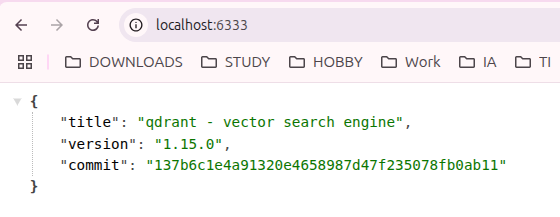

In [33]:
qd_client = QdrantClient("http://127.0.0.1:6333")

In [34]:
EMBEDDING_DIMENSIONALITY = 512
collection_name = "hw3-faq"

In [35]:
qd_client.delete_collection(collection_name=collection_name)

False

In [36]:
qd_client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=EMBEDDING_DIMENSIONALITY,
        distance=models.Distance.COSINE
    )
)

True

In [37]:
qd_client.create_payload_index(
    collection_name=collection_name,
    field_name="course",
    field_schema="keyword"
)

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

In [38]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [39]:
points = []

for i, doc in enumerate(documents):
    text = doc['question'] + ' ' + doc['text']
    vector = models.Document(text=text, model=model_handle)
    point = models.PointStruct(
        id=i,
        vector=vector,
        payload=doc
    )
    points.append(point)

In [ ]:
qd_client.upsert(
    collection_name=collection_name,
    points=points
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

onnx/model.onnx:   0%|          | 0.00/130M [00:00<?, ?B/s]

In [ ]:
def vector_search_qdrant(question, course):
    
    course = course
    query_points = qd_client.query_points(
        collection_name=collection_name,
        query=models.Document(
            text=question,
            model=model_handle 
        ),
        query_filter=models.Filter( 
            must=[
                models.FieldCondition(
                    key="course",
                    match=models.MatchValue(value=course)
                )
            ]
        ),
        limit=5,
        with_payload=True
    )
    
    results = []
    
    for point in query_points.points:
        results.append(point.payload)
    
    return results

In [ ]:
evaluate_results = evaluate(ground_truth, lambda q: vector_search_qdrant(q['question'], q['course']))
evaluate_results["mrr"]

What's the MRR?

## Q5. Cosine simiarity

In the second part of the module, we looked at evaluating the entire RAG approach. In particular, we looked at comparing the answer generated by our system with the actual answer from the FAQ.

One of the ways of doing it is using the cosine similarity. Let's see how to calculate it.

Cosine similarity is a dot product between two normalized vectors. In geometrical sense, it's the cosine of the angle between the vectors. Look up "cosine similarity geometry" if you want to learn more about it.

For us, it means that we need two things:

* First, we normalize each of the vectors
* Then, compute the dot product

So, we get this:

In [ ]:
def cosine(u, v):
    u = normalize(u)
    v = normalize(v)
    return u.dot(v)

For normalization, we first compute the vector norm (its length), and then divide the vector by it:

In [ ]:
def normalize(u):
    norm = np.sqrt(u.dot(u))
    return u / norm